# \[WIP] Exploratory Data Analysis for Data Driven Modelling

Welcome to using the data-driven notebook for evaluating datasets for building simulators in preparation of Machine Teaching with [Project Bonsai](https://docs.microsoft.com/en-us/bonsai/)! 

The goal of this repository is to help you with learning state transitions,  $f(s_t, a_t, c_t) \to s_{t+1}$ from existing data. While this approach is growing in popularity its vitality depends on the _reliability_ and _coverage_ of your dataset. Our approach makes some key assumptions:

- You have merged all data into a single CSV, where the columns are variables and rows are observations.
- The dataset contains:
    * State variables
    * Action variable(s)
    * Configuration variable(s) (optional)
    * Episode labels (optional for now, but will be required)
    * Iteration labels (optional for now, but will be required)
- All columns are numeric (or can be casted to numeric)
- The recorded frequency is high enough to capture your system's dynamics.

## Recipe for Validation

Here is a recipe for validating the dataset you are using for data-driven simulator building.

1. View high-level information describing your dataset
2. Check for missing values (NULLs and non-numbers) and apply any necessary preprocessors or transformations.
3. Check for outliers.
4. Check for data sparsity by viewing distributional support or coverage of states, actions and configs. 
5. (Optional) Check for discontinuity in episode iterations.
5. Save any transformed data and the transformation functions to appropriate folders for data-driven simulator training

### Library Imports

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import binned_statistic_dd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os
from hydra.experimental import compose, initialize_config_dir
from omegaconf import OmegaConf

sns.set_context(rc={"grid.linewidth": 0})

### Load Data

Add you data file to ./datadrivenmodel/csv_data/.

In [2]:
# Generates the data path
dir_path = os.path.dirname(os.getcwd())
data_path = os.path.join(dir_path, "csv_data/house-energy.csv")
# Reads into a pandas dataframe
df = pd.read_csv(data_path)
# Prints 5 random rows
df.sample(5)

/Users/jill/opt/anaconda3/envs/ddm/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Tset,Tin,Tout,power,K,C,Qhvac,horizon,Tin_initial,Tout_median,Tout_amplitude,Tset_start,Tset_stop,Tset_transition,episode,iteration,hvacON
8892,20,9.900416,20.052848,27,0.5,0.3,9,288,27.550196,23.656883,3.635134,25,20,103,31,223,1.0
41041,25,20.376277,24.075159,27,0.5,0.3,9,288,28.570850,23.800290,4.202683,25,21,139,143,4,1.0
41814,21,15.456805,23.106522,0,0.5,0.3,9,288,29.335938,27.176467,4.405277,25,21,102,145,199,0.0
30653,25,17.946028,25.980139,27,0.5,0.3,9,288,26.508024,24.135537,4.580054,25,22,122,107,20,1.0
41905,25,18.391656,29.630758,0,0.5,0.3,9,288,18.391656,29.630758,4.841247,25,22,135,146,1,NaN


## 1. Basic Dataset Information 

Choose the states, configs, and actions.

In [3]:
# Define state variables
state_vars = ['Tset', 'Tin', 'Tout']

# Define configuration variables
config_vars = ['K','C','Qhvac','horizon','Tin_initial','Tout_median', 
               'Tout_amplitude','Tset_start','Tset_stop', 'Tset_transition']

# Define action variables
action_vars = ['hvacON']

Sort data by timestamp.

In [4]:
# Timestamp column, enter None if data are already sorted.
time_col = None

# Sort by time in ascending order.
if time_col: df.sort_values(time_col, inplace=True)

Choose your action frequency. Sometimes, it takes time for the system to respond to actuations. As an example, it may take more than 15 minutes to respond to temperature or pressure changes in a plant. If you have data recorded every minute, then you need to re-arrange your data to look at 15 minutes steps. In the code below, you can easily achieve this by changing the time_lag from 1 to 15 below **as long as your data are continuous in time**.

In [5]:
# Rows between actions
time_lag = 1

# Resample dataset and view
df = df.iloc[::time_lag,:]
df.head()

,Tset,Tin,Tout,power,K,C,Qhvac,horizon,Tin_initial,Tout_median,Tout_amplitude,Tset_start,Tset_stop,Tset_transition,episode,iteration,hvacON
0,25,29.183617,26.160638,0,0.5,0.3,9,288,29.183617,26.160638,4.395635,25,22,test,1,1,NaN
1,25,26.263759,26.256528,27,0.5,0.3,9,288,29.183617,26.160638,4.395635,25,22,128,1,2,1.0
2,25,23.762755,26.352373,27,0.5,0.3,9,288,29.183617,26.160638,4.395635,25,22,128,1,3,1.0
3,25,21.622424,26.448126,27,0.5,0.3,9,288,29.183617,26.160638,4.395635,25,22,128,1,4,1.0
4,25,22.292660,26.543743,0,0.5,0.3,9,288,29.183617,26.160638,4.395635,25,22,128,1,5,0.0


In [6]:
# Prints basic counts
print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])
print("Number of states:", len(state_vars))
print("Number of configs:", len(config_vars))
print("Number of actions:", len(action_vars))

Number of rows: 43350
Number of columns: 17
Number of states: 3
Number of configs: 10
Number of actions: 1


## 2. Check for Missing Values 

In [7]:
## Check for nans and datatypes other than numbers
def hasNaN(x_set):
    nan_catcher = np.zeros((1, x_set.shape[1]))
    type_catcher = np.zeros((1, x_set.shape[1]))
    catcher = []

    i = 0
    for column_name, column_data in x_set.iteritems():
        catcher_col = []
        for row in column_data.values:
            # Check for NULL
            if pd.isnull(row):
                nan_catcher[0, i] += 1
            else:
                # Check if value can be cast to numeric
                try:
                    row = float(row)
                except:
                    type_catcher[0, i] += 1
                    catcher_col.append(row)
        catcher.append(catcher_col)
        i += 1

    return nan_catcher, type_catcher, catcher


# Loop through all columns to check for invalid cells
nan_count, type_count, _ = hasNaN(df)
for i in range(0, df.shape[1]):
    print('Detected {} NaN and {} type issues in column {}: type error for {}'.format(
        int(nan_count[0, i]), int(type_count[0, i]), df.columns[i], set(_[i])))

Detected 0 NaN and 0 type issues in column Tset: type error for set()
Detected 0 NaN and 0 type issues in column Tin: type error for set()
Detected 0 NaN and 0 type issues in column Tout: type error for set()
Detected 0 NaN and 0 type issues in column power: type error for set()
Detected 0 NaN and 0 type issues in column K: type error for set()
Detected 0 NaN and 0 type issues in column C: type error for set()
Detected 0 NaN and 0 type issues in column Qhvac: type error for set()
Detected 0 NaN and 0 type issues in column horizon: type error for set()
Detected 0 NaN and 0 type issues in column Tin_initial: type error for set()
Detected 0 NaN and 0 type issues in column Tout_median: type error for set()
Detected 0 NaN and 0 type issues in column Tout_amplitude: type error for set()
Detected 0 NaN and 0 type issues in column Tset_start: type error for set()
Detected 0 NaN and 0 type issues in column Tset_stop: type error for set()
Detected 0 NaN and 1 type issues in column Tset_transitio

Decide whether you want to remove rows with missing values or [impute null values](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.impute) (be careful!). The cells below will remove rows with missing values. If data are limited, consider imputation rather than removal. You may also want to consider removing columns with a large % of missing values before removing rows.

In [8]:
# Converts all columns to numeric. Value errors are replaced with null.
df = df.apply(pd.to_numeric, errors="coerce")

In [9]:
# Removes rows with null values. See comment above if removal doesn't make sense for your application.
df.dropna(inplace=True)

## 3. Variable Ranges and Outlier Detection

Decide how you want to compute outliers. The code below uses a classical statistics method to look for values outside of the [interquartile range](https://en.wikipedia.org/wiki/Interquartile_range). A better approach might be to ask the SME for the appropriate range of variables (upper and lower thresholds).

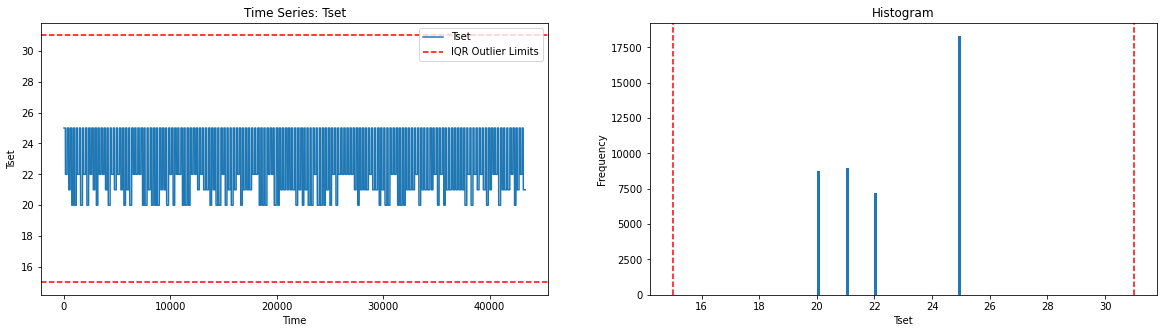

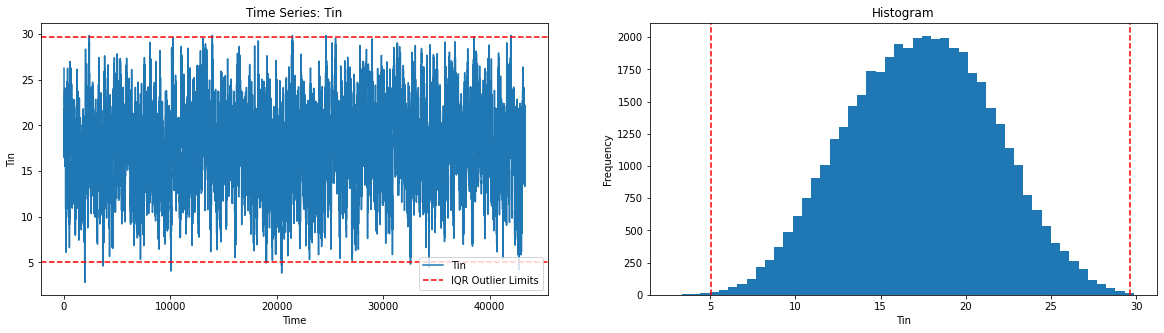

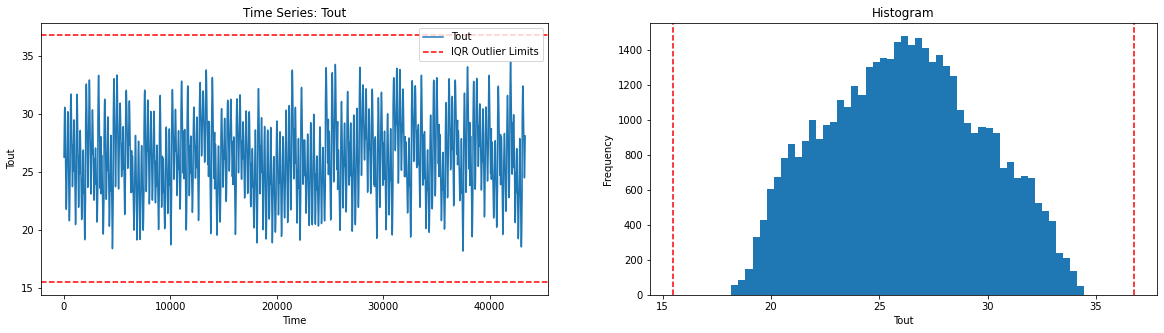

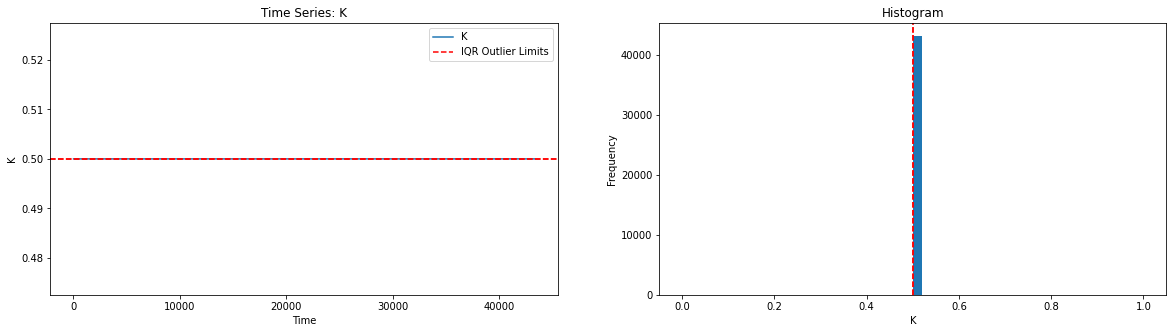

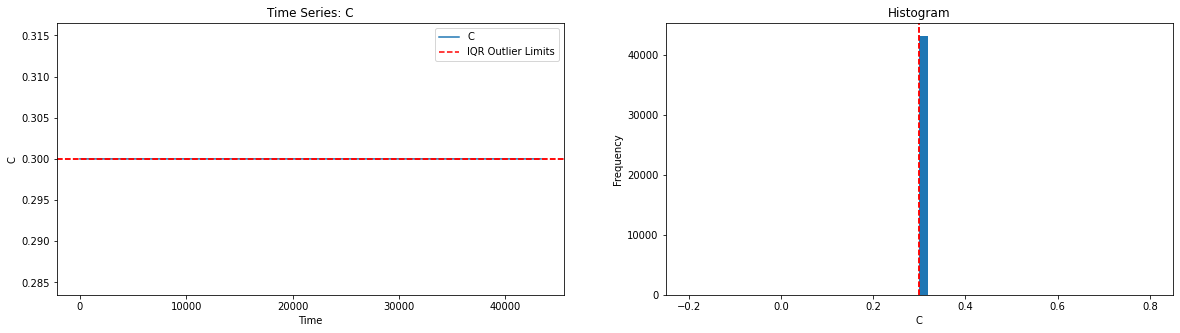

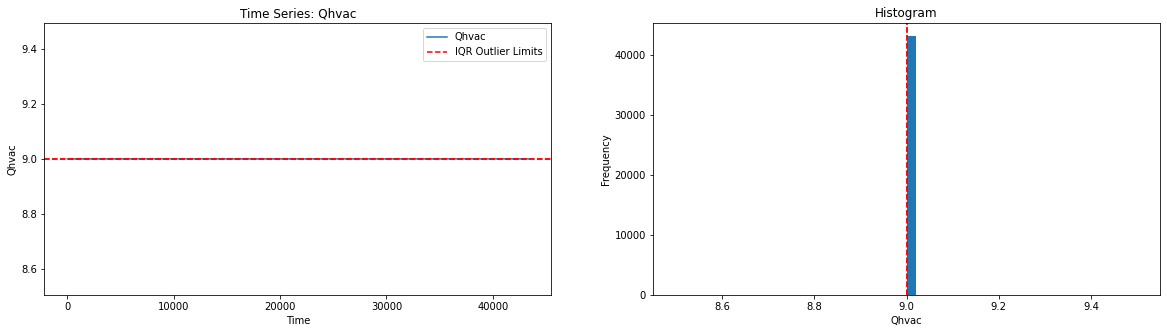

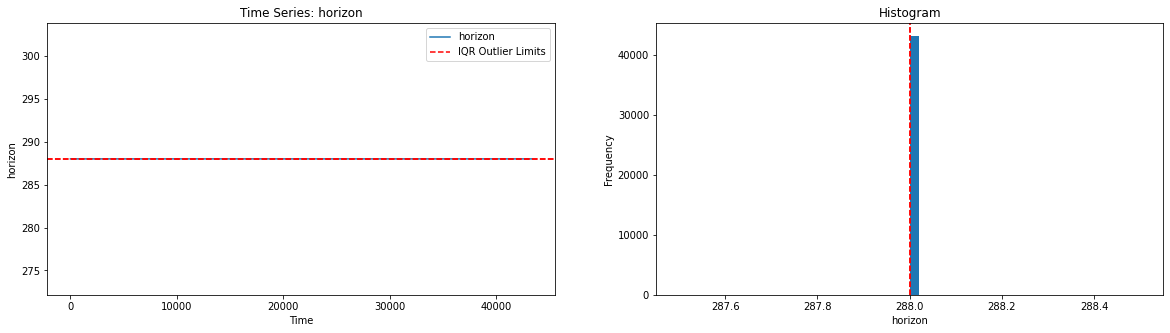

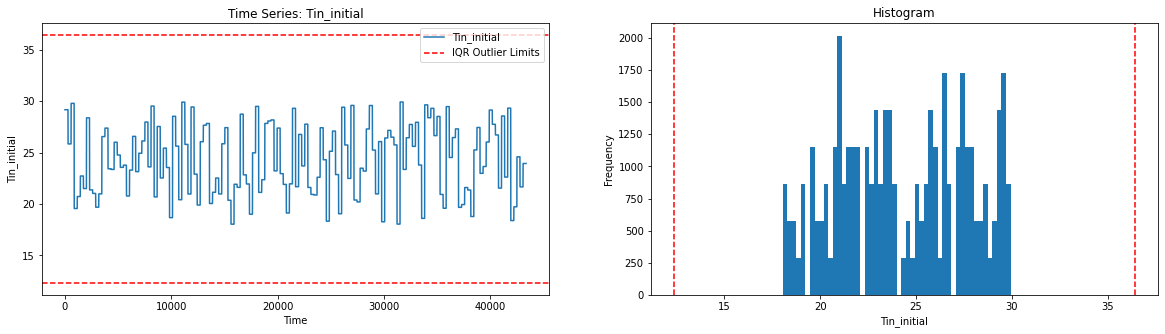

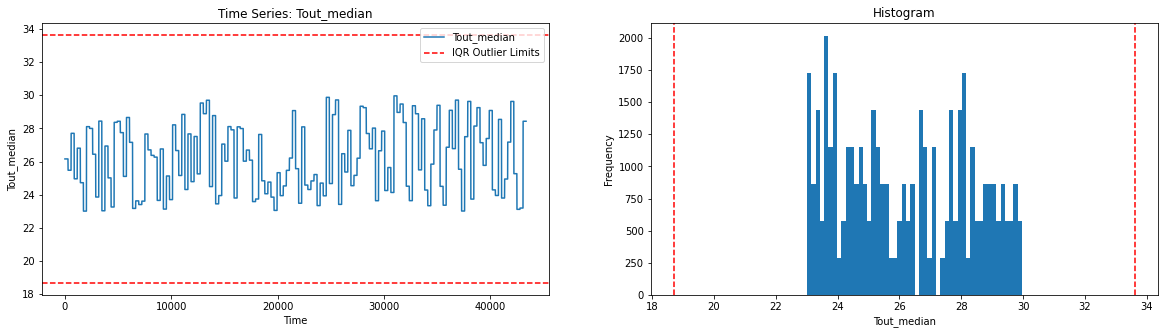

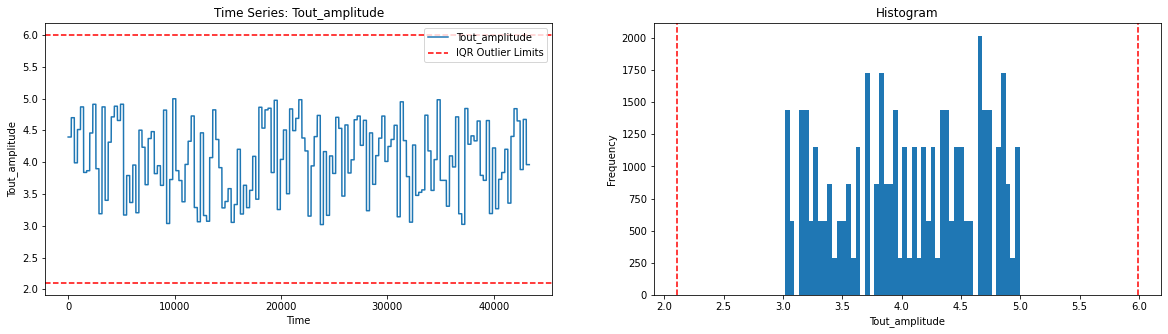

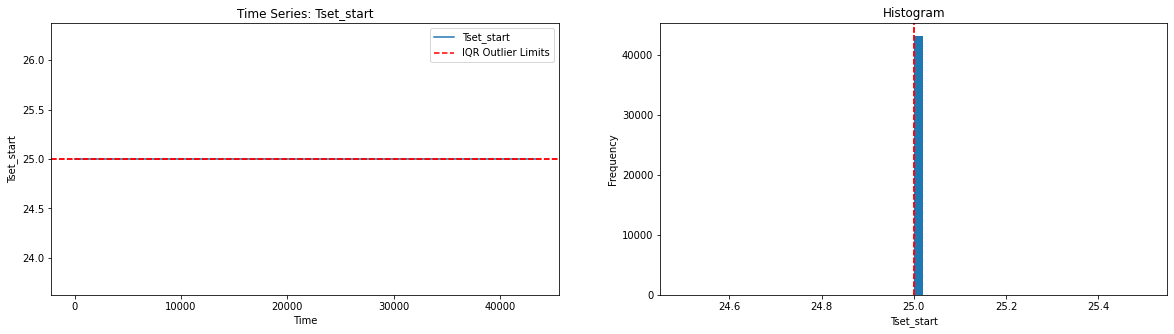

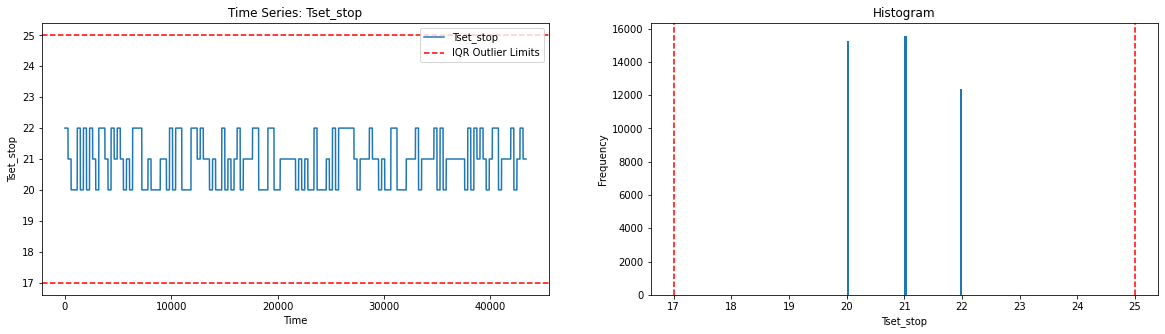

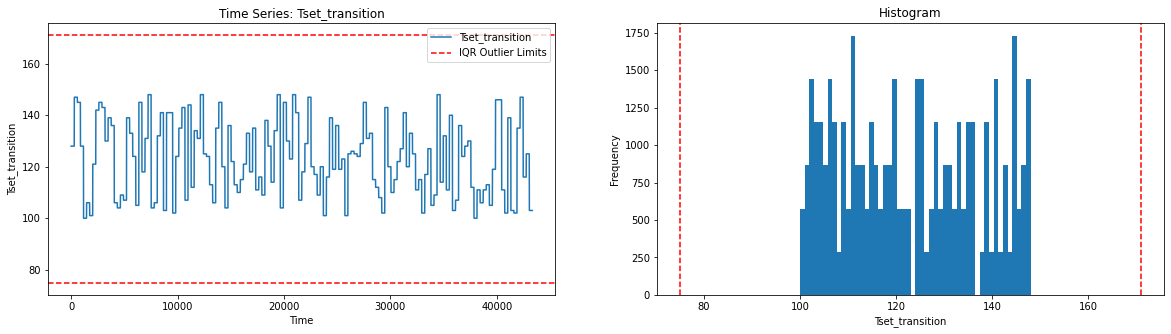

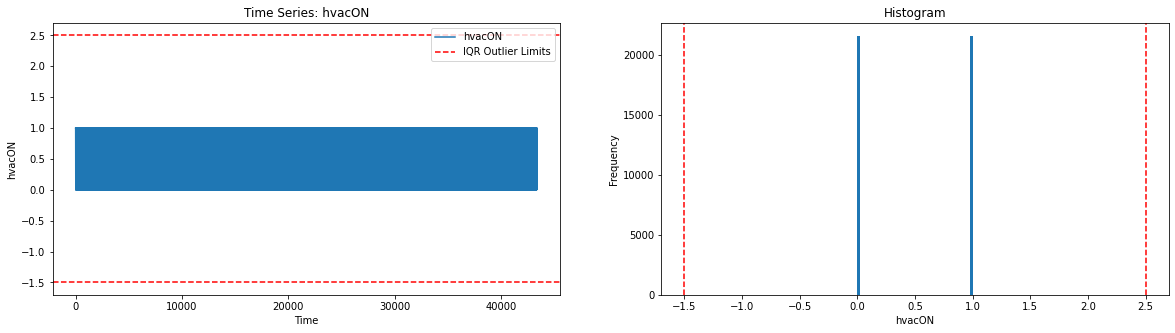

In [10]:
# Plot variables (time series + histograms). Red lines indicate IQR thresholds for outliers.
# NOTE: Red lines are not ground truth for defining outliers. 
for col in state_vars + config_vars + action_vars:
    fig = plt.figure(figsize=(20,5))

    # Plot time series
    plt.subplot(1,2,1)
    df[col].plot()
    plt.xlabel('Time')
    plt.ylabel(col)
    plt.title('Time Series: ' + col)
    
    # Plot lines indicating outliers according to the IQR Rule
    Q1 = np.percentile(df[col], 25, interpolation = 'midpoint') 
    Q3 = np.percentile(df[col], 75, interpolation = 'midpoint') 
    IQR = Q3 - Q1
    lower_lim = Q1 - 1.5 * IQR 
    upper_lim = Q3 + 1.5 * IQR 
    plt.axhline(y=lower_lim,color='r',linestyle='--')
    plt.axhline(y=upper_lim,color='r',linestyle='--')
    plt.legend([col,'IQR Outlier Limits'])

    # Plot histogram 
    plt.subplot(1,2,2)
    df[col].hist(bins=50)
    plt.axvline(x=lower_lim,color='r',linestyle='--')
    plt.axvline(x=upper_lim,color='r',linestyle='--')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title('Histogram')

While outliers can skew and mislead the training process, certain prediction algorithms are robust to them (e.g., XGBoost). Consider discussing outliers with the SME to determine if they are due to measurement error (can be ignored/capped/imputed) or are due to abnormal system behavior and the observation should be removed.

NOTE: It might be difficult for the RL agent to explore regions surrounding outliers due to *data sparsity*. Continue to the next section for more on this.

## 4. Check for Data Sparsity

*Data sparsity* occurs when your model doesn’t generalize across the space gaps (where data doesn't exist) in the actual data. The data needs to cover all state, configuration, and action space regions where a potential optimal solution exists. In this section, we'll try to visualize sparsity in your dataset.

In the plots below, look for empty regions in the pair plots to determine where data may be missing/spase. Consider asking the customer to collect more data in those regions **if an optimal solution could exist there**. For example, in the house-energy example, it's unlikely you will want to turn on the AC when it's extremely cold outside, so it's OK for

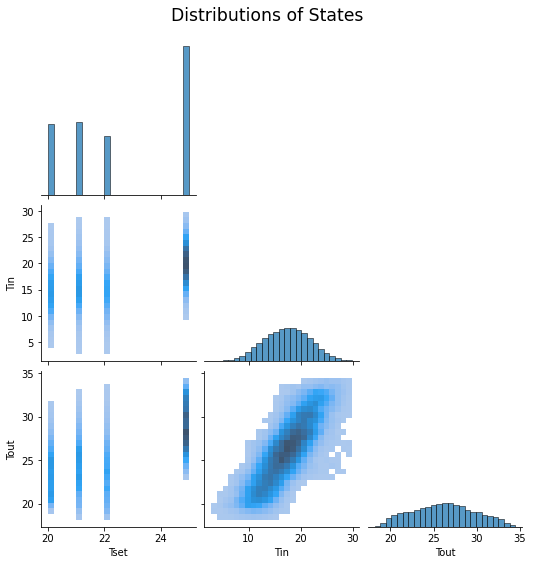

In [11]:
# Plots the distributions of States
g = sns.pairplot(
    df[state_vars],
    kind="hist",
    diag_kind="hist",
    corner=True,
    plot_kws={"bins": 25},
    diag_kws={"bins": 25},
)
g.fig.suptitle("Distributions of States", size="xx-large", y=1.04);

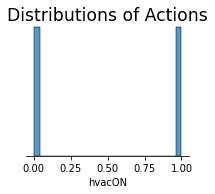

In [12]:
# Plots the distributions of Actions
g = sns.pairplot(
    df[action_vars],
    kind="hist",
    diag_kind="hist",
    corner=True,
    plot_kws={"bins": 25},
    diag_kws={"bins": 25},
)
g.fig.suptitle("Distributions of Actions", size="xx-large", y=1.04);

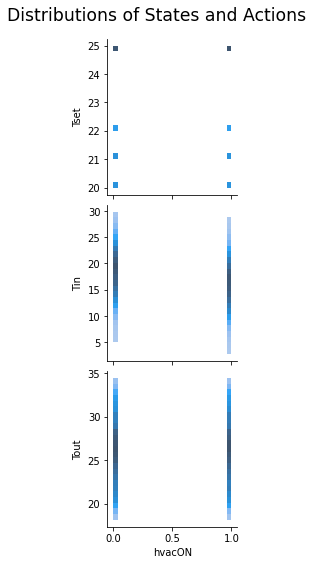

In [13]:
# Plots the distributions of States and Actions
g = sns.pairplot(
    df,
    x_vars=action_vars,
    y_vars=state_vars,
    kind="hist",
    diag_kind=None,
    plot_kws={"bins": 25},
)
g.fig.suptitle("Distributions of States and Actions", size="xx-large", y=1.04);

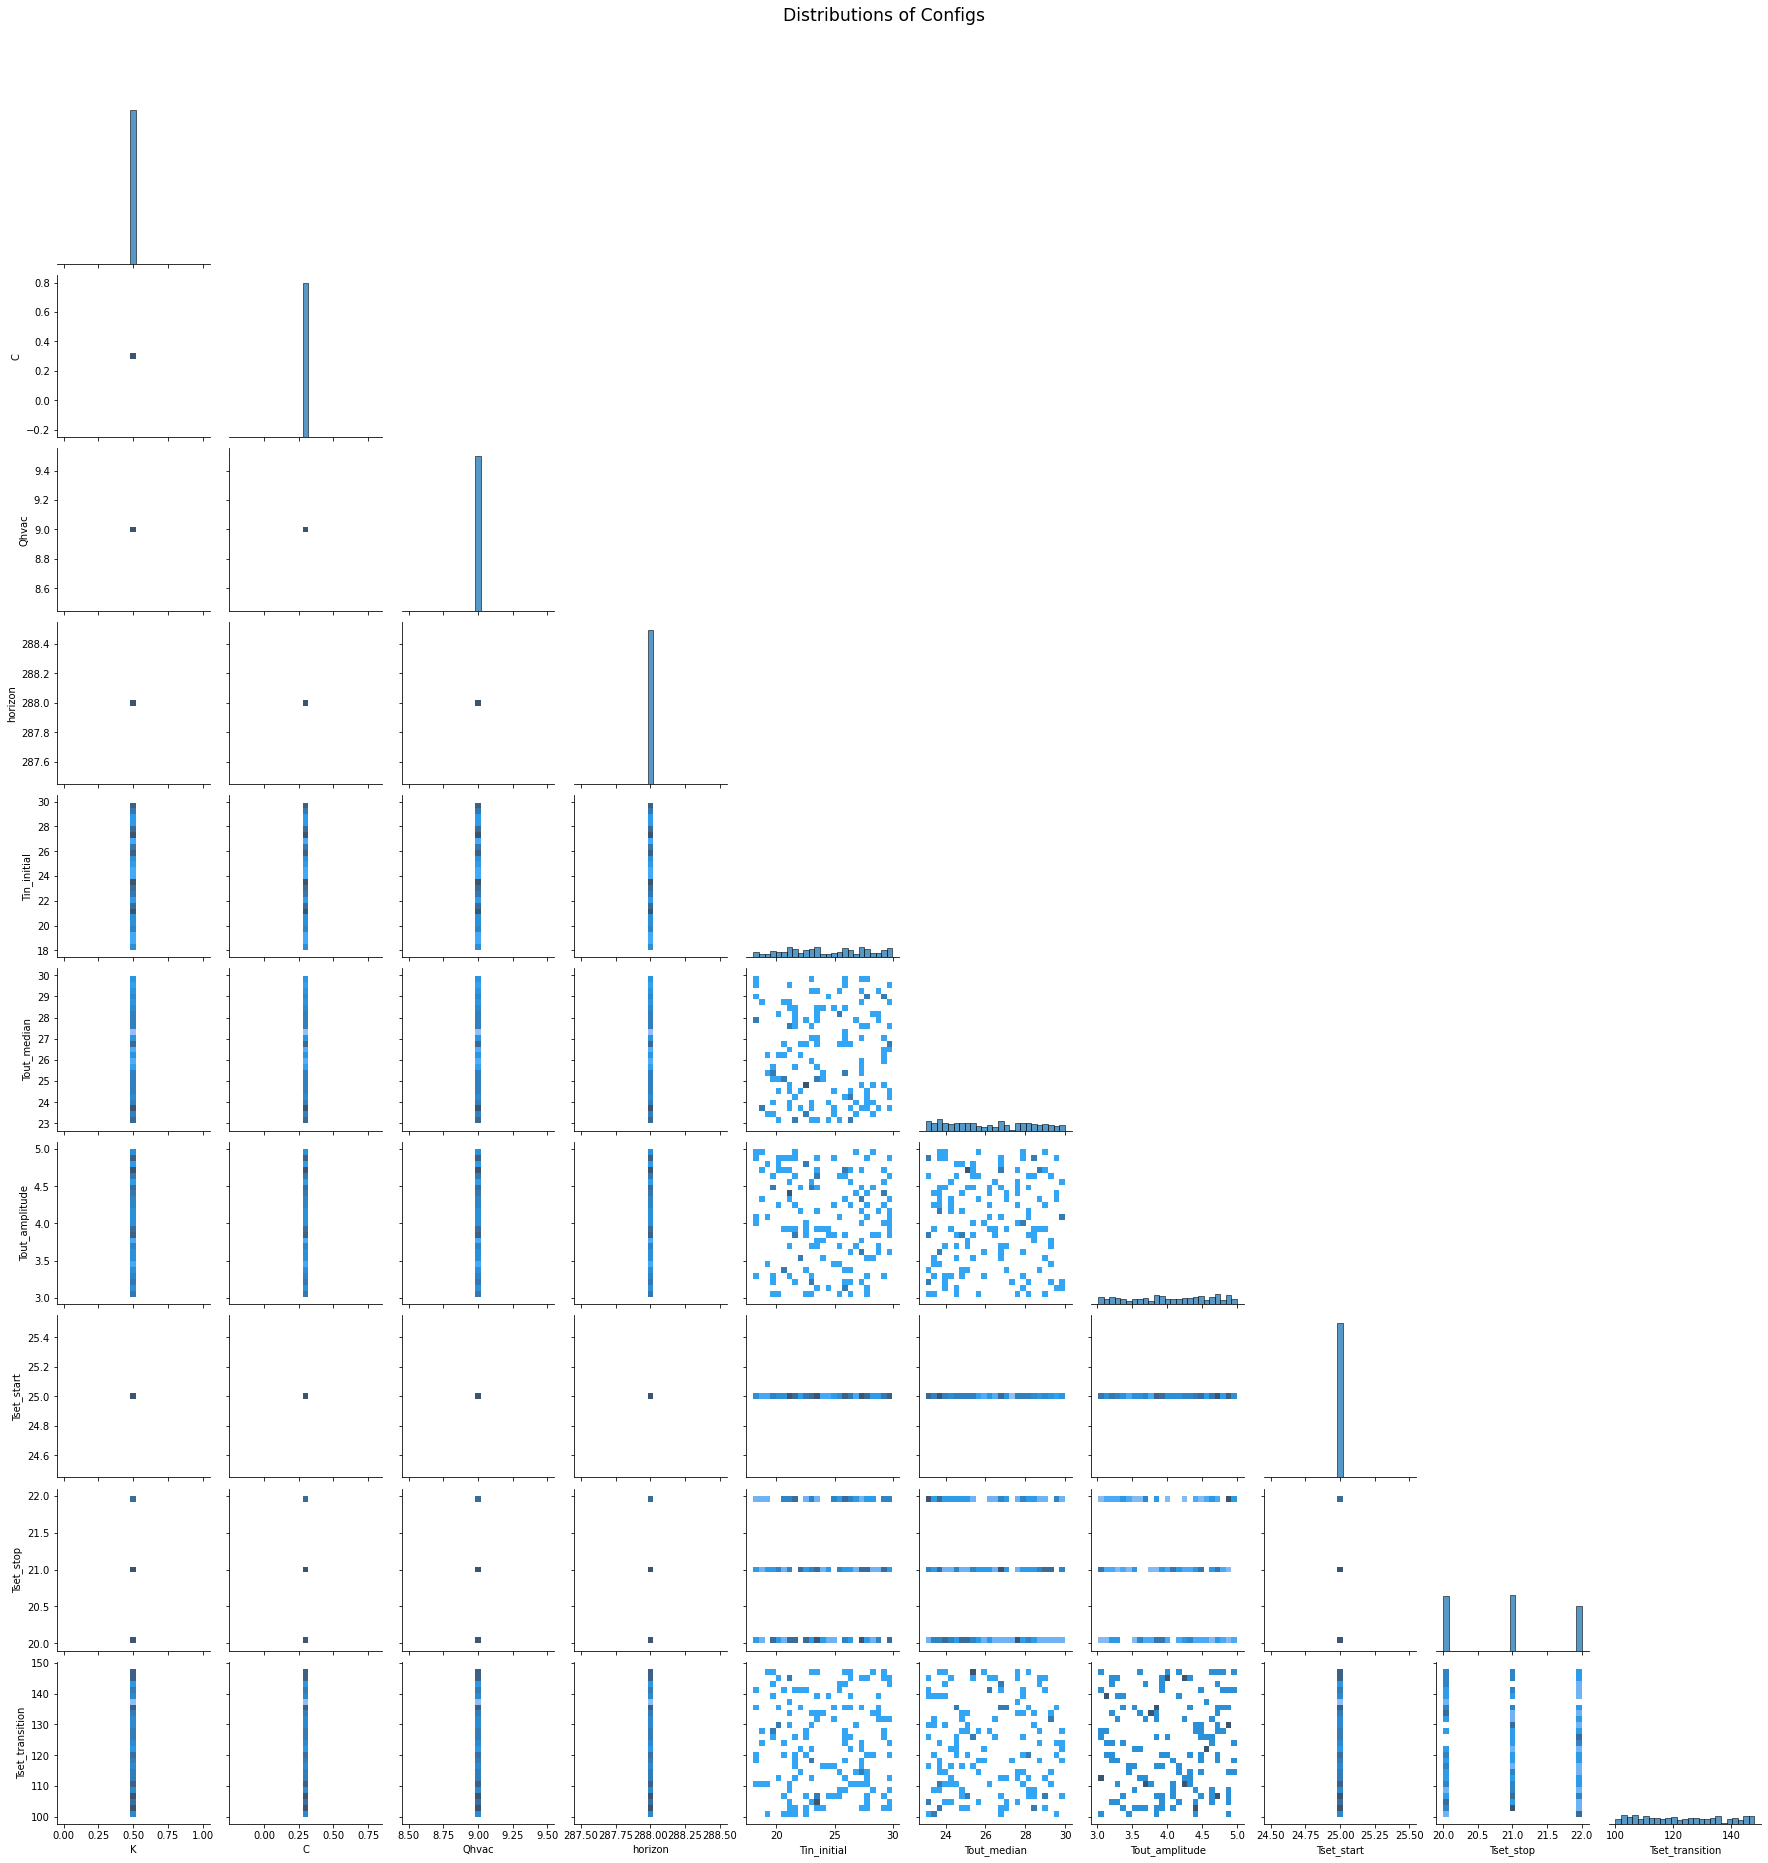

In [14]:
g = sns.pairplot(
    df[config_vars],
    kind="hist",
    diag_kind="hist",
    corner=True,
    plot_kws={"bins": 25},
    diag_kws={"bins": 25},
)
g.fig.suptitle("Distributions of Configs", size="xx-large", y=1.04);

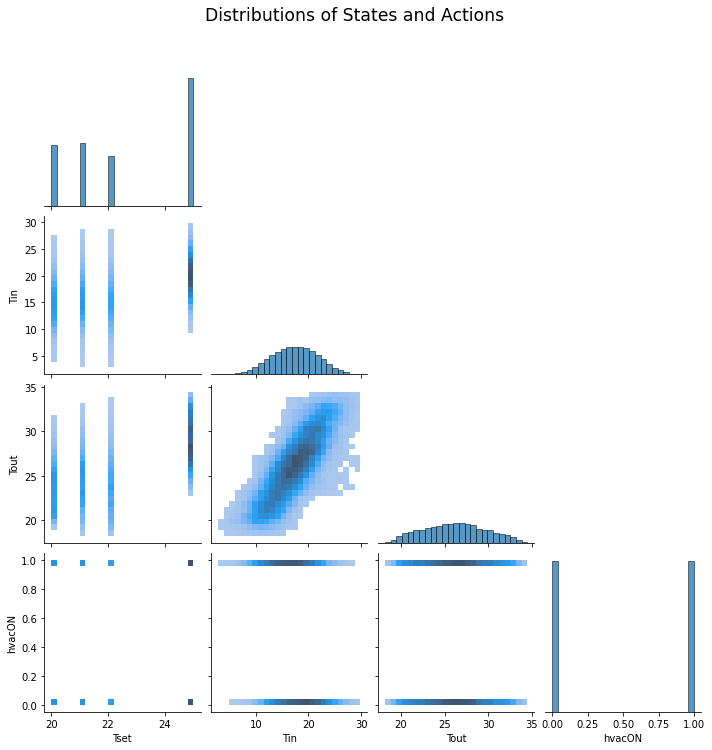

In [15]:
g = sns.pairplot(
    df[state_vars + action_vars],
    kind="hist",
    diag_kind="hist",
    corner=True,
    plot_kws={"bins": 25},
    diag_kws={"bins": 25},
)
g.fig.suptitle("Distributions of States and Actions", size="xx-large", y=1.04);

## 5. (Optional) Episode/Iteration Analysis

In [16]:
print("Number of episodes:", df["episode"].nunique())
# Calculates Episode Lengths (max value of 'iteration')
episode_lengths = df.groupby("episode")["iteration"].count()
print("Shortest episode: {} iteration(s)".format(episode_lengths.min()))
print("Longest episode: {} iteration(s)".format(episode_lengths.max()))

Number of episodes: 150
Shortest episode: 288 iteration(s)
Longest episode: 288 iteration(s)


/Users/jill/opt/anaconda3/envs/ddm/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Users/jill/opt/anaconda3/envs/ddm/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


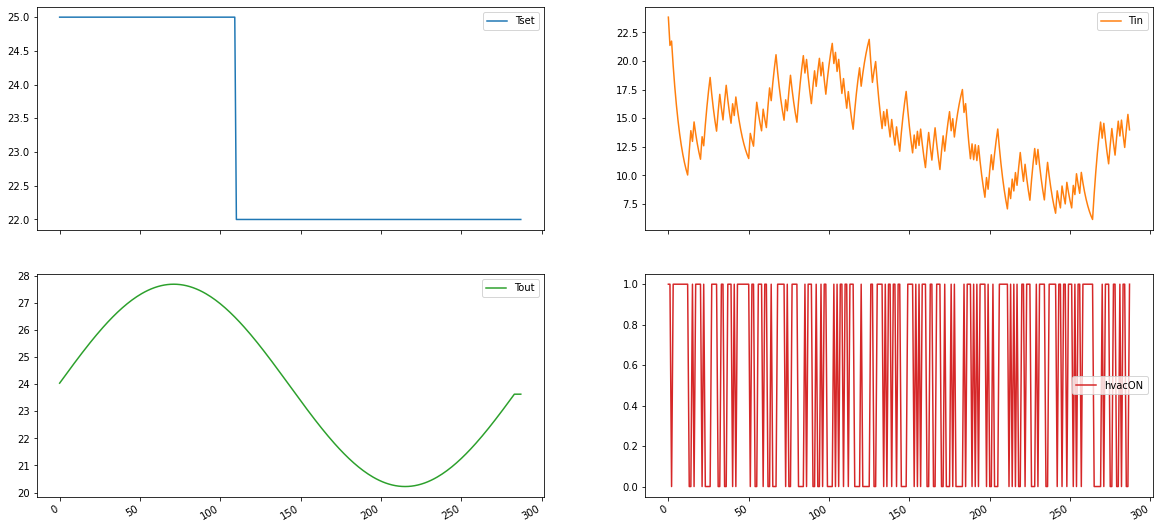

In [17]:
# Plots states and actions of a random episode
random_episode = random.choice(df["episode"])
random_day_data = df.loc[
    df["episode"] == random_episode, state_vars + action_vars
].reset_index(drop=True)
random_day_data.plot(subplots=True, figsize=(20, 10), layout=(-1, 2));

In [18]:
# Find "breaks" in an episode's iteration sequence
df['episode_break'] = df.groupby("episode")['iteration'].diff()>1
# Sum of breaks across episode
episodes = (
    df.groupby("episode")
    .agg(
        total_breaks=("episode_break", "sum"),
    )
)
# Valid episodes are where there are no breaks
valid_episodes = episodes.index[
   (
        episodes["total_breaks"] == 0
    )
]

In [19]:
# Drops all rows with invalid episodes
df.drop(df.loc[~df["episode"].isin(valid_episodes)].index, inplace=True)
# Resets the index
df.reset_index(drop=True, inplace=True)

## 6. Save final dataset

In [20]:
# New filename to save processed data
new_filename = "house-energy-eda.csv"
# Save data as a CSV in same location as the current dataset
df.to_csv(os.path.join(dir_path, "csv_data/"+new_filename))